In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

In [2]:
import numpy as np
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from modules.lib.ChextXRayImages import *
from modules.lib.Metrics import *
from modules.lib.TrainingLoop import *
from modules.models.CustomPneumonia import CustomPneumoniaNN

from PIL import Image
import copy

import torch.optim as optim
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models

from torchsummary import summary

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')


Working on device=cuda


In [4]:
loaders = Loaders()
batch_size=1
val_percent=0.20
number_images = 2000
train_loader, val_loader = loaders.getDataTrainValidateLoaders(batch_size=batch_size, 
                                                                        val_percent=val_percent, 
                                                                        n_random_rows=number_images)

target_columns = loaders.target_columns
train_actual = loaders.train_df
val_actual = loaders.val_df

print(f'Number of Training Batches: {len(train_loader):,}')
print(f'Number of Validation Batches: {len(val_loader):,}')
print(f'Number of Training Images: {len(train_loader) * batch_size:,}')
print(f'Number of Validation Images: {len(val_loader) * batch_size:,}')

Number of Training Batches: 1,612
Number of Validation Batches: 388
Number of Training Images: 1,612
Number of Validation Images: 388


In [5]:
net = CustomPneumoniaNN()

net = nn.DataParallel(net)
net.to(device)

summary(net, (1, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 512, 320, 320]          13,312
       BatchNorm2d-2        [-1, 512, 320, 320]           1,024
         MaxPool2d-3        [-1, 512, 160, 160]               0
            Conv2d-4        [-1, 256, 160, 160]       1,179,904
       BatchNorm2d-5        [-1, 256, 160, 160]             512
         MaxPool2d-6          [-1, 256, 80, 80]               0
            Conv2d-7           [-1, 64, 80, 80]         147,520
       BatchNorm2d-8           [-1, 64, 80, 80]             128
         MaxPool2d-9           [-1, 64, 40, 40]               0
           Linear-10                 [-1, 1024]     104,858,624
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 512]         524,800
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [6]:
learning_rate = 1e-4
num_epochs = 6
# torch.set_num_threads(1)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

metrics = Metrics(target_columns, train_actual, val_actual, cc=0)
trainingLoop = TrainingLoop(device, net, optimizer, criterion, metrics)

In [7]:
help(Metrics.displayMetrics)

Help on function displayMetrics in module modules.lib.Metrics:

displayMetrics(self, metricDataSource=<MetricDataSource.Both: 0>, showCombinedMetrics=True, showMetricDataFrame=True, showROCCurves=True, showPrecisionRecallCurves=True, include_targets=None, combinedAverageMethod='samples', gridSpecColumnCount=4, gridSpecHeight=3, gridSpecWidth=20)
    docstring



In [8]:
trainingLoop.epoch_metric_display_args = (0, True, False, False, False,  ['Edema', 'Lung_Opacity', 'Pneumonia'])

In [9]:
trainingLoop.train(num_epochs, train_loader, val_loader)

Epoch [1/6]
Epoch Loss: 670.9399         
Training Time: 0:02:22.104133)          
Validation Time: 0:00:07.289768)

TRAINING



,Score for all Targets
Accuracy Score,0.097395
Hamming Loss,0.158499
Combined Recall,0.147374
Combined Precision,0.230718
Combined F1,0.166037



VALIDATION



,Score for all Targets
Accuracy Score,0.198454
Hamming Loss,0.137887
Combined Recall,0.000000
Combined Precision,0.000000
Combined F1,0.000000


Epoch [2/6]
Epoch Loss: 591.1660         
Training Time: 0:02:22.739430)          
Validation Time: 0:00:07.367306)

TRAINING



,Score for all Targets
Accuracy Score,0.140819
Hamming Loss,0.144644
Combined Recall,0.119737
Combined Precision,0.208023
Combined F1,0.142804



VALIDATION



,Score for all Targets
Accuracy Score,0.198454
Hamming Loss,0.137887
Combined Recall,0.000000
Combined Precision,0.000000
Combined F1,0.000000


Epoch [3/6]
Epoch Loss: 580.6138         
Training Time: 0:02:17.299397)          
Validation Time: 0:00:06.822761)

TRAINING



,Score for all Targets
Accuracy Score,0.155707
Hamming Loss,0.139733
Combined Recall,0.100827
Combined Precision,0.189103
Combined F1,0.124507



VALIDATION



,Score for all Targets
Accuracy Score,0.198454
Hamming Loss,0.137887
Combined Recall,0.000000
Combined Precision,0.000000
Combined F1,0.000000


Epoch [4/6]
Epoch Loss: 564.1757         
Training Time: 0:02:07.063425)          
Validation Time: 0:00:06.838788)

TRAINING



,Score for all Targets
Accuracy Score,0.151985
Hamming Loss,0.138958
Combined Recall,0.079849
Combined Precision,0.151158
Combined F1,0.099338



VALIDATION



,Score for all Targets
Accuracy Score,0.172680
Hamming Loss,0.135309
Combined Recall,0.086770
Combined Precision,0.170103
Combined F1,0.109708


Epoch [5/6]
Epoch Loss: 555.6684         
Training Time: 0:02:06.710325)          
Validation Time: 0:00:06.833705)

TRAINING



,Score for all Targets
Accuracy Score,0.161911
Hamming Loss,0.138854
Combined Recall,0.080232
Combined Precision,0.146402
Combined F1,0.097956



VALIDATION



,Score for all Targets
Accuracy Score,0.198454
Hamming Loss,0.138101
Combined Recall,0.000000
Combined Precision,0.000000
Combined F1,0.000000


Epoch [6/6]
Epoch Loss: 553.1667         
Training Time: 0:02:05.663370)          
Validation Time: 0:00:07.021234)

TRAINING



,Score for all Targets
Accuracy Score,0.163151
Hamming Loss,0.138441
Combined Recall,0.071919
Combined Precision,0.128412
Combined F1,0.087531



VALIDATION



,Score for all Targets
Accuracy Score,0.198454
Hamming Loss,0.137887
Combined Recall,0.000000
Combined Precision,0.000000
Combined F1,0.000000



TRAINING



,Score for all Targets
Accuracy Score,0.163151
Hamming Loss,0.138441
Combined Recall,0.071919
Combined Precision,0.128412
Combined F1,0.087531


C:\Users\youci\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,80,0.000000,0.000000,0.000000,0.560411,0.068823
1,Cardiomegaly,191,0.000000,0.000000,0.000000,0.508693,0.121402
2,Lung_Opacity,725,0.273103,0.441964,0.337596,0.504958,0.443578
3,Lung_Lesion,80,0.000000,0.000000,0.000000,0.529561,0.059763
4,Edema,387,0.000000,0.000000,0.000000,0.522535,0.253133
5,Consolidation,74,0.000000,0.000000,0.000000,0.544046,0.060888
6,Pneumonia,48,0.000000,0.000000,0.000000,0.456735,0.028528
7,Atelectasis,270,0.000000,0.000000,0.000000,0.512113,0.171217
8,Pneumothorax,142,0.000000,0.000000,0.000000,0.463275,0.082977
9,Pleural_Effusion,545,0.031193,0.404762,0.057922,0.518098,0.351763


***** ROC *****


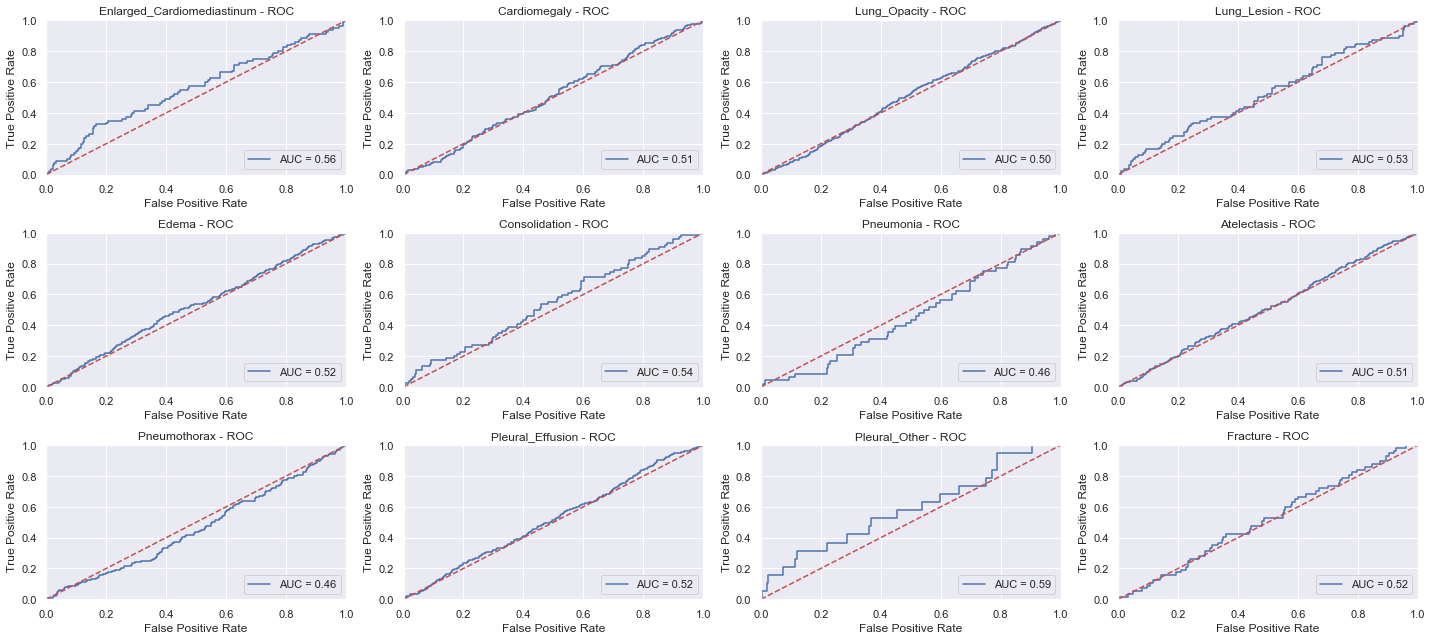

***** Precision / Recall *****


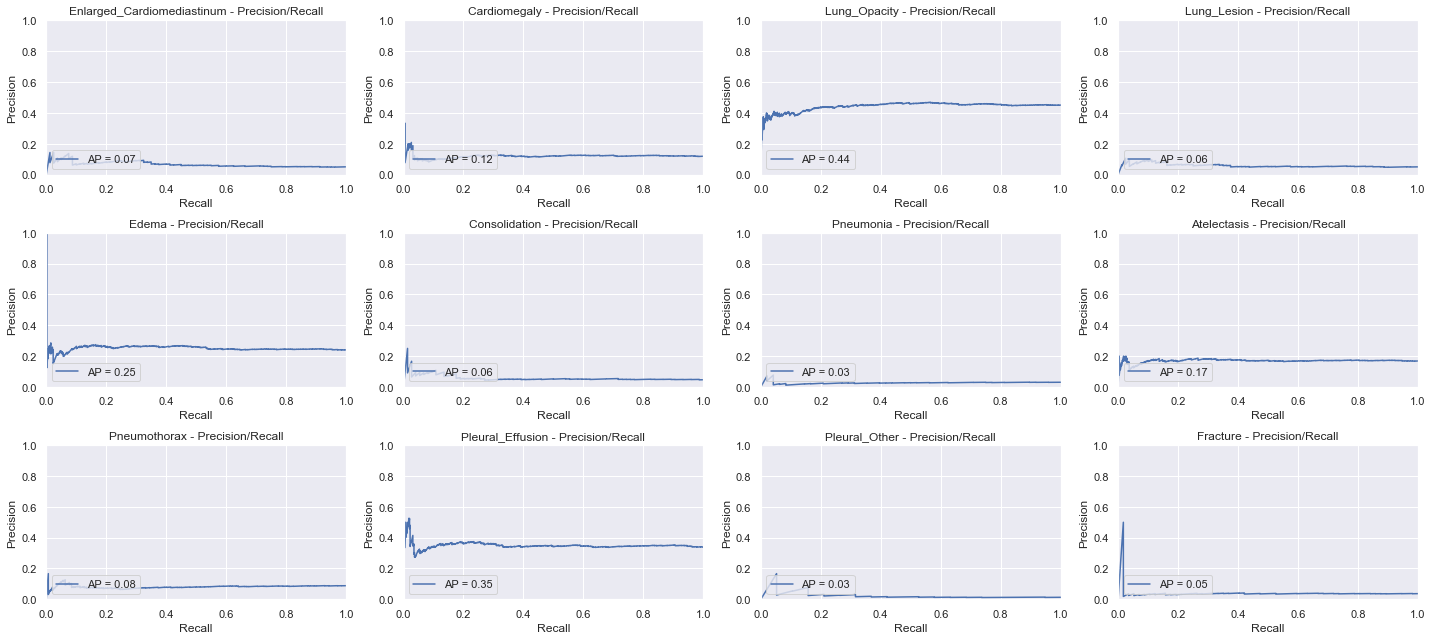


VALIDATION



,Score for all Targets
Accuracy Score,0.198454
Hamming Loss,0.137887
Combined Recall,0.000000
Combined Precision,0.000000
Combined F1,0.000000


C:\Users\youci\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,20,0.0,0.0,0.0,0.344565,0.038402
1,Cardiomegaly,43,0.0,0.0,0.0,0.435592,0.095173
2,Lung_Opacity,190,0.0,0.0,0.0,0.446890,0.440101
3,Lung_Lesion,21,0.0,0.0,0.0,0.584663,0.072711
4,Edema,95,0.0,0.0,0.0,0.517873,0.246075
5,Consolidation,23,0.0,0.0,0.0,0.518404,0.065497
6,Pneumonia,7,0.0,0.0,0.0,0.497188,0.025538
7,Atelectasis,60,0.0,0.0,0.0,0.483740,0.141755
8,Pneumothorax,28,0.0,0.0,0.0,0.549901,0.098690
9,Pleural_Effusion,136,0.0,0.0,0.0,0.644929,0.445235


***** ROC *****


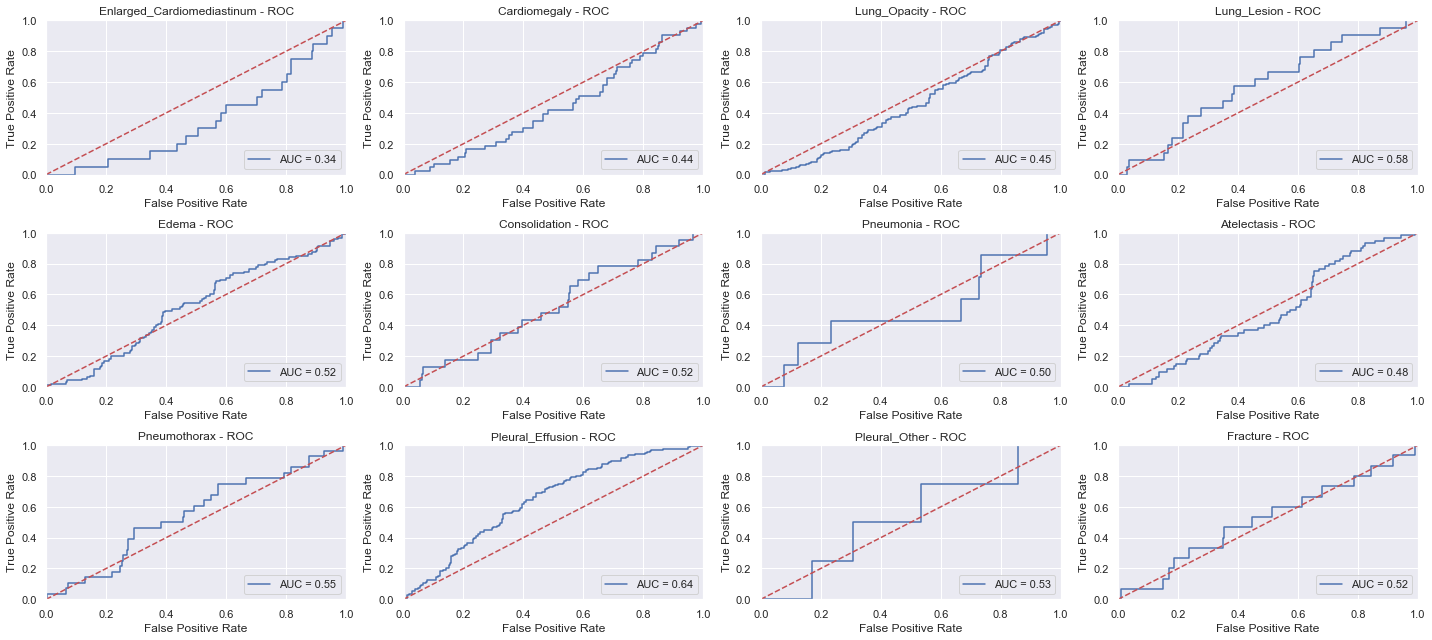

***** Precision / Recall *****


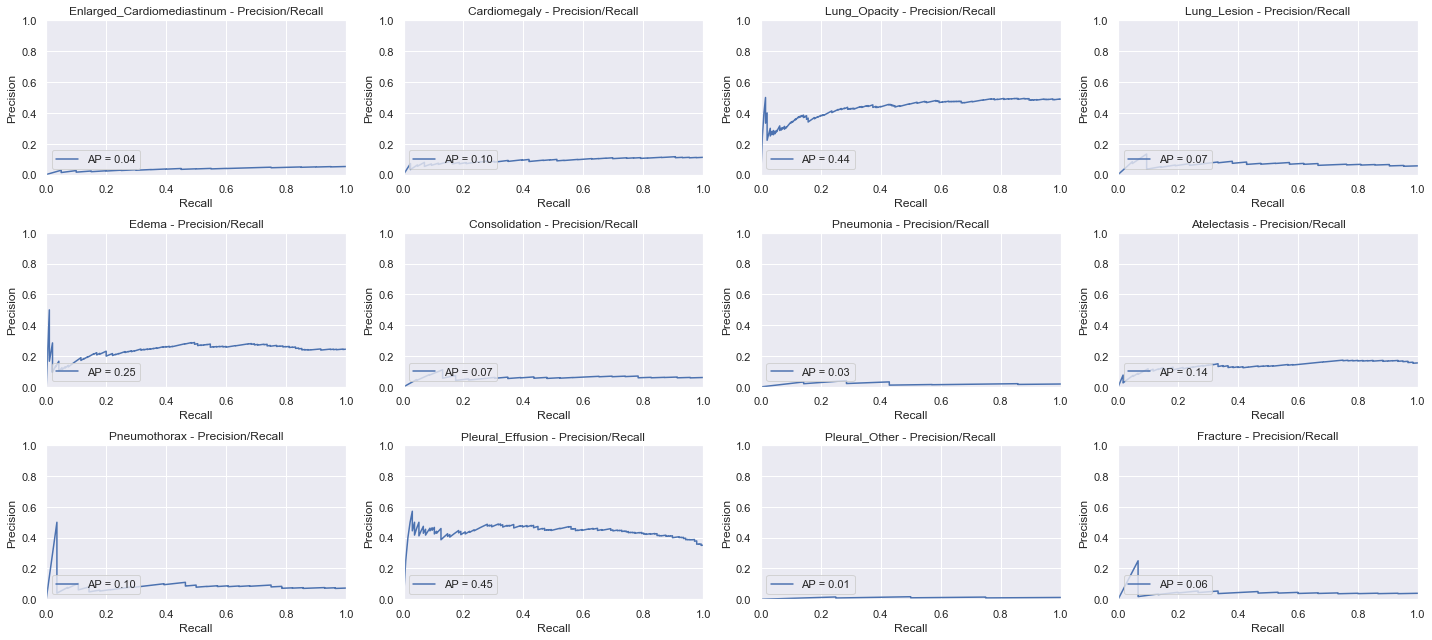

In [10]:
metrics.displayMetrics()